<a href="https://colab.research.google.com/github/modanmodern/modanmodern/blob/tensorflow-study/Vision%20Deep%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36830 (\N{CJK UNIFIED IDEOGRAPH-8FDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32493 (\N{CJK UNIFIED IDEOGRAPH-7EED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 34928 (\N{CJK UNIFIED IDEOGRAPH-8870}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

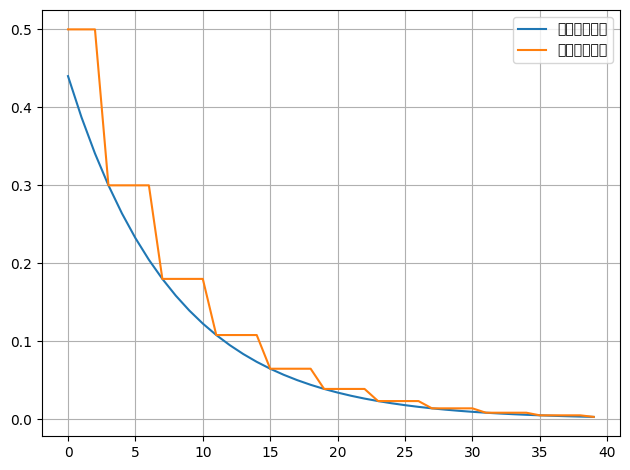

In [1]:
import numpy as np
import matplotlib.pyplot as plt


lr_base = 0.5  # 初始学习率
decay_rate = 0.6  # 指数衰减率
decay_step = 4  # 衰减步数

epoch = 10
batch = 4

lr, lr_stair = [], []  # 存储学习率变化
global_step = 0
for epoch in range(epoch):
    for step in range(batch):
        global_step += 1  # 统计迭代次数
        lr_temp = lr_base * decay_rate ** (global_step / decay_step)  # 连续学习率衰减
        lr_stair_temp = lr_base * decay_rate ** (np.floor(global_step / decay_step))  # 向下取整，阶梯衰减
        lr.append(lr_temp)
        lr_stair.append(lr_stair_temp)

fig, ax = plt.subplots(tight_layout=True)
ax.plot(lr, label='连续指数衰减')
ax.plot(lr_stair, label='阶梯指数衰减')
ax.legend(prop={'family':'SimHei'})
ax.grid()
plt.show()

In [4]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

**学习率（Learning Rate）**
学习率是深度学习中最重要的参数之一。它决定了模型在每次更新时所采用的权重大小。如果学习率设置得过大，可能会导致模型无法收敛；如果学习率设置得过小，则模型可能需要很长时间才能收敛，甚至可能无法收敛。
一般来说，较大的学习率可以加速模型的训练，但可能会导致模型震荡或者无法收敛。较小的学习率可以使得模型更稳定，但可能会使得模型训练速度变慢。因此，选择一个合适的learning rate是非常重要的。
通常通过随机搜索或者贝叶斯优化等方法进行learning rate的调优。
**批量大小（Batch Size）**
批量大小是指在每次更新时，所使用的样本数量。批量大小会影响模型的训练速度和收敛速度。较小的批量大小可以加速模型的训练，但可能会导致模型收敛到局部最优解。较大的批量大小可以使得模型更稳定，但可能会使得模型训练速度变慢。
在选择批量大小时，需要权衡速度和稳定性。通常情况下，我们会使用较小的批量大小来加速训练，然后在训练后期逐渐增加批量大小以提高模型的精度。
**迭代次数（Epochs）**
迭代次数是指整个数据集被训练的次数。迭代次数越多，模型对数据的拟合程度越好，但同时也会增加过拟合的风险。太少或者太多的迭代次数都会对模型的性能产生影响。
一般情况下，我们会先设置一个较小的迭代次数进行训练，然后在训练过程中逐步增加迭代次数。也可以通过设置早停（early stopping）或者学习率衰减（learning rate decay）等方式来控制模型的训练过程，防止过拟合。
**正则化参数（Regularization Parameters）**
正则化参数主要用于控制模型的复杂度，以减少过拟合的风险。常用的正则化参数包括L1正则化、L2正则化和Dropout等。
L1正则化可以使得模型更加稀疏，有助于提高模型的泛化能力；L2正则化则可以使得模型的权重更加均匀，有助于防止模型过度拟合训练数据；Dropout可以在训练过程中随机关闭部分神经元，以增加模型的泛化能力。
在调整正则化参数时，通常需要通过交叉验证等方式来选择合适的参数。例如，可以通过交叉验证来选择最佳的L1/**L2正则化比例或者Dropout比例。**

In [12]:
import tensorflow as tf
# 导入所需的工具库
# tensorflow建模
from tensorflow.keras import models, layers, utils, backend as K
# 可视化
import matplotlib.pyplot as plt
# 特征重要度与模型归因分析
import shap

# 定义激活函数
def binary_step_activation(x):
    ## 如果x>0返回1否则返回0
    return K.switch(x>0, tf.math.divide(x,x), tf.math.multiply(x,0))

'''
抽取tensorflow.keras模型中的每层信息
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential不显示输入层
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0,
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units,
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0,
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers
'''
绘制神经网络的草图
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## 获取层次信息
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    ## 绘图设置
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    ## 中间节点
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        ### 添加信息说明
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        ### 遍历
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            ### 添加文本说明
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    ## 添加链接箭头等
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left],
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space],
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# 构建模型
model = models.Sequential(name="Perceptron1", layers=[
      layers.Dense(name="dense1",input_dim=3,units=1,activation=binary_step_activation)
])

# 感知器
inputs = layers.Input(name="input", shape=(3,))
outputs = layers.Dense(name="output", units=1,
                       activation='linear')(inputs)
model = models.Model(inputs=inputs, outputs=outputs,
                     name="Perceptron")
# 深层神经网络
# 输入层
inputs = layers.Input(name="input", shape=(n_features,))
# 隐层1
h1 = layers.Dense(name="h1", units=int(round((n_features+1)/2)), activation='relu')(inputs)
h1 = layers.Dropout(name="drop1", rate=0.2)(h1)
# 隐层2
h2 = layers.Dense(name="h2", units=int(round((n_features+1)/4)), activation='relu')(h1)
h2 = layers.Dropout(name="drop2", rate=0.2)(h2)
# 输出层
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
# 完整的模型
model = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")

visualize_nn(model, description=True, figsize=(10,8))

ModuleNotFoundError: No module named 'shap'

In [13]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 7.3 MB/s eta 0:00:00


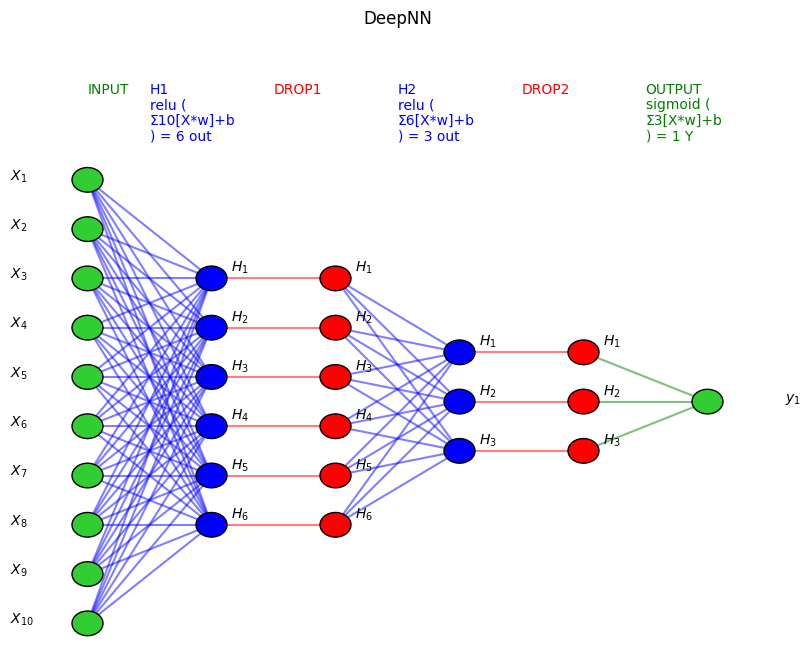

In [16]:
import tensorflow as tf
# 导入所需的工具库
# tensorflow建模
from tensorflow.keras import models, layers, utils, backend as K
# 可视化
import matplotlib.pyplot as plt
# 特征重要度与模型归因分析
import shap

# 定义激活函数
def binary_step_activation(x):
    ## 如果x>0返回1否则返回0
    return K.switch(x>0, tf.math.divide(x,x), tf.math.multiply(x,0))

'''
抽取tensorflow.keras模型中的每层信息
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential不显示输入层
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0,
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units,
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0,
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers
'''
绘制神经网络的草图
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## 获取层次信息
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    ## 绘图设置
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    ## 中间节点
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        ### 添加信息说明
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        ### 遍历
        for m in range(n):
            color = "limegreen" if color == "green" else color
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/4.0, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            ### 添加文本说明
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    ## 添加链接箭头等
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left],
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space],
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# 构建模型
model = models.Sequential(name="Perceptron", layers=[
      layers.Dense(name="dense",input_dim=3,units=1,activation=binary_step_activation)
])

# 感知器
inputs = layers.Input(name="input", shape=(3,))
outputs = layers.Dense(name="output", units=1,
                       activation='linear')(inputs)
model = models.Model(inputs=inputs, outputs=outputs,
                     name="Perceptron")

# 深层神经网络
n_features = 10

# 输入层
inputs = layers.Input(name="input", shape=(n_features,))
# 隐层1
h1 = layers.Dense(name="h1", units=int(round((n_features+1)/2)), activation='relu')(inputs)
h1 = layers.Dropout(name="drop1", rate=0.2)(h1)
# 隐层2
h2 = layers.Dense(name="h2", units=int(round((n_features+1)/4)), activation='relu')(h1)
h2 = layers.Dropout(name="drop2", rate=0.2)(h2)
# 输出层
outputs = layers.Dense(name="output", units=1, activation='sigmoid')(h2)
# 完整的模型
model = models.Model(inputs=inputs, outputs=outputs, name="DeepNN")

visualize_nn(model, description=True, figsize=(10,8))